In [13]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from l2_pipeline import L2DatasetLoader

In [14]:
data_dir = r"E:\satdata"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} files.")

Found 204 files.


In [15]:
loader = L2DatasetLoader(variable='chlor_a')
datasets = loader.load_multiple(nc_files)
len(datasets)

204

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import cupy as cp
from concurrent.futures import ThreadPoolExecutor

# ========== SETTINGS ==========
datasets_subset = datasets  # Assuming `datasets` is preloaded

# ========== GPU DATA EXTRACTION FUNCTION ==========
def extract_data_gpu(ds):
    # Convert to CuPy for GPU processing
    var = cp.asarray(ds['chlor_a'].values).flatten()
    lat = cp.asarray(ds['lat'].values).flatten()
    lon = cp.asarray(ds['lon'].values).flatten()

    # Mask NaNs on GPU
    mask = ~cp.isnan(var) & ~cp.isnan(lat) & ~cp.isnan(lon)

    # Filter and convert back to NumPy for plotting
    return (
        cp.asnumpy(lon[mask]),
        cp.asnumpy(lat[mask]),
        cp.asnumpy(var[mask])
    )

# ========== RUN EXTRACTION IN PARALLEL ==========
with ThreadPoolExecutor() as executor:
    results = list(executor.map(extract_data_gpu, datasets_subset))

# ========== CONCATENATE ALL GPU-PROCESSED RESULTS ==========
all_lon = np.concatenate([r[0] for r in results])
all_lat = np.concatenate([r[1] for r in results])
all_var = np.concatenate([r[2] for r in results])

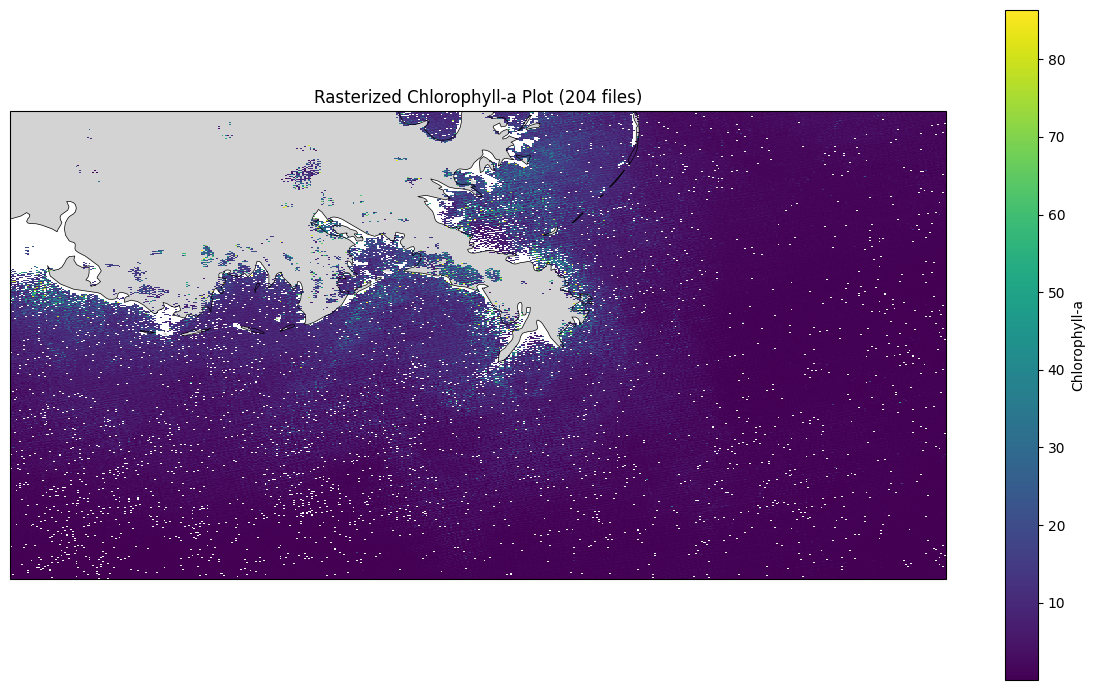

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import numpy as np

# Define bounding box
lon_min, lon_max = -91.5, -87.5
lat_min, lat_max = 28.0, 30.0

# Clip data to bounding box
mask = (
    (all_lon >= lon_min) & (all_lon <= lon_max) &
    (all_lat >= lat_min) & (all_lat <= lat_max)
)
clipped_lon = all_lon[mask]
clipped_lat = all_lat[mask]
clipped_var = all_var[mask]

# Number of bins
lat_bins, lon_bins = 250, 300

# Compute 2D binned mean statistic
stat, lat_edges, lon_edges, _ = binned_statistic_2d(
    clipped_lat, clipped_lon, clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
    range=[[lat_min, lat_max], [lon_min, lon_max]]
)

# Meshgrid for pcolormesh (use edges)
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

# ========== PLOTTING ==========
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the raster data
raster = ax.pcolormesh(
    lon_grid, lat_grid, stat,
    cmap='viridis', shading='auto',
    transform=ccrs.PlateCarree()
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Colorbar and title
plt.colorbar(raster, label='Chlorophyll-a')
plt.title(f"Rasterized Chlorophyll-a Plot ({len(datasets_subset)} files)")
plt.tight_layout()
plt.show()
